In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neural_network import MLPClassifier

df = pd.read_csv('data/preprocessed_heart_failure_dataset.csv')
feature_column_names = ['age', 'anemia', 'creatine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
continuous_features = ['age', 'creatine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

X = df.copy().drop(columns=['patient_deceased'])
y = df['patient_deceased'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
standardizer = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), continuous_features)
    ],
    remainder='passthrough'
)

def create_table(table_data: list[list], title: str):
  fig, ax = plt.subplots()
  ax.axis('off')
  table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=None)
  ax.set_title(title)
  table.auto_set_font_size(False)
  table.set_fontsize(10)
  table.scale(1.2, 1.2)
  plt.show()

In [ ]:
test_metrics_data = []
test_metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Model']

def create_test_metrics_row(y_test, y_pred, model_name):
  return [
    round(accuracy_score(y_test, y_pred), 3),
    round(precision_score(y_test, y_pred), 3),
    round(recall_score(y_test, y_pred), 3),
    round(f1_score(y_test, y_pred), 3),
    round(roc_auc_score(y_test, y_pred), 3),
    model_name
  ]

# Logistic Regression

## Hyperparameter Tuning With Stratified K-Fold CV and Grid Search CV

In [ ]:
logistic_pipeline = Pipeline([
    ('scale', standardizer),
    ('logistic', LogisticRegression())
])

param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 0.5, 1, 10, 25],
}

stratkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score, zero_division=1),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

logistic_grid_search = GridSearchCV(logistic_pipeline, param_grid, scoring=scoring, refit='accuracy', cv=stratkf, n_jobs=-1)
logistic_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'creatine_phosphokinase',
                                                                          'ejection_fraction',
                                                                          'platelets',
                                                                          'serum_creatinine',
                                                                          'serum_sodium'])])),
                                       ('logistic', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.001, 0.01, 0.1, 0.5, 1, 10, 25]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score, needs_proba=True)})

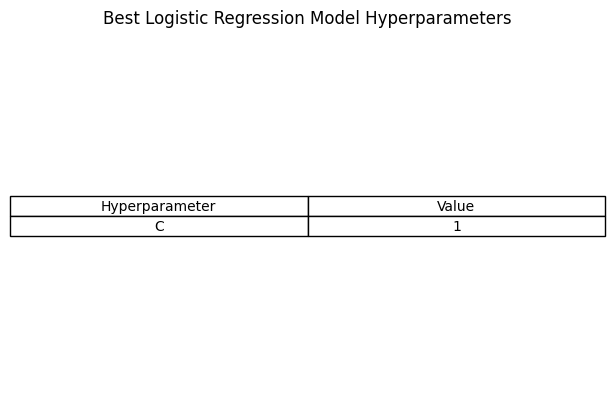

In [ ]:
log_regression_hyperparameter_table = [
    ["Hyperparameter", "Value"]
]

for key, val in logistic_grid_search.best_params_.items():
  log_regression_hyperparameter_table.append([key.replace('logistic__', ''), val])

create_table(log_regression_hyperparameter_table, 'Best Logistic Regression Model Hyperparameters')

## Model Metric Scores on Training Set

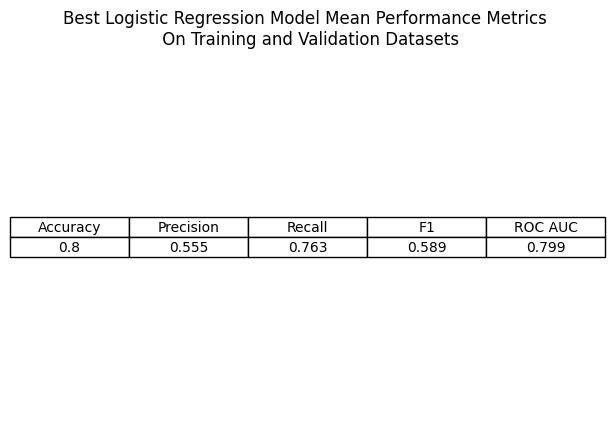

In [ ]:
log_regression_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

best_model_indx = logistic_grid_search.best_index_
scoring_types = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
model_data = []

for st in scoring_types:
  model_data.append(round(logistic_grid_search.cv_results_[f'mean_test_{st}'][best_model_indx], 3))

log_regression_metrics_table.append(model_data)

create_table(log_regression_metrics_table, 'Best Logistic Regression Model Mean Performance Metrics \n On Training and Validation Datasets')

## Model Metric Scores on Testing Set

In [ ]:
log_y_pred = logistic_grid_search.predict(X_test)

log_test_metrics = create_test_metrics_row(y_test, log_y_pred, 'Logistic Regression')

test_metrics_data.append(log_test_metrics)

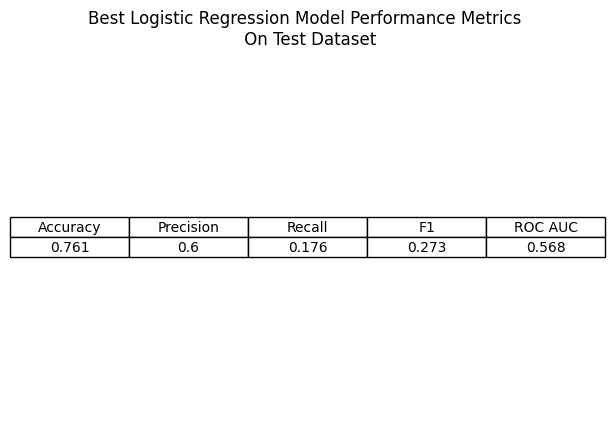

In [ ]:
log_test_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

log_test_metrics_table.append(log_test_metrics[:len(log_test_metrics) - 1])

create_table(log_test_metrics_table, 'Best Logistic Regression Model Performance Metrics \n On Test Dataset')

In [ ]:
target_names = ['class 0: Patient Not Deceased', 'class 1: Patient Deceased']
print(classification_report(y_test, log_y_pred, target_names=target_names))

                               precision    recall  f1-score   support

class 0: Patient Not Deceased       0.77      0.96      0.86        50
    class 1: Patient Deceased       0.60      0.18      0.27        17

                     accuracy                           0.76        67
                    macro avg       0.69      0.57      0.56        67
                 weighted avg       0.73      0.76      0.71        67



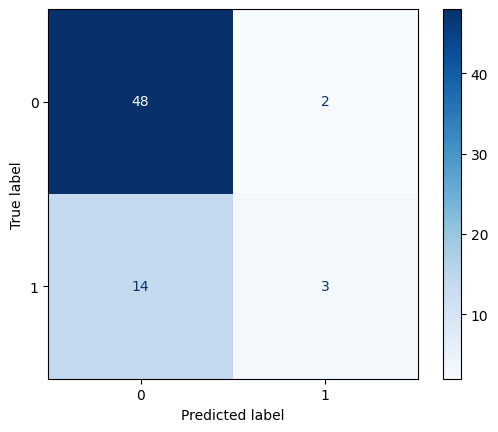

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, log_y_pred, cmap=plt.cm.Blues)

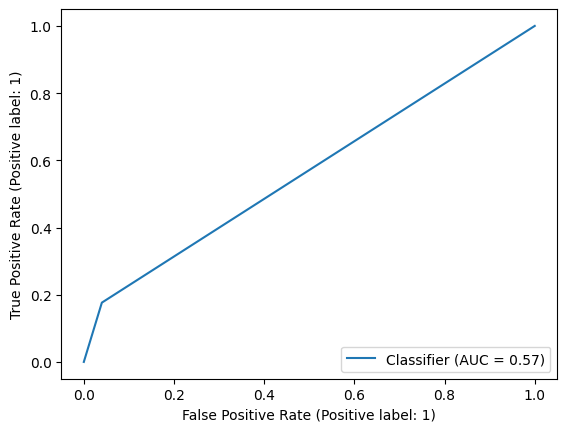

In [ ]:
RocCurveDisplay.from_predictions(y_test, log_y_pred)

# KNN

## Hyperparameter Tuning With StratifiedKFold and GridSearchCV

In [ ]:
knn_pipeline = Pipeline([
    ('scaler', standardizer),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [1, 3, 9, 17, 25, 50],
}

stratkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score, zero_division=1),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

knn_grid_search = GridSearchCV(knn_pipeline, param_grid, scoring=scoring, refit='accuracy', cv=stratkf, n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'creatine_phosphokinase',
                                                                          'ejection_fraction',
                                                                          'platelets',
                                                                          'serum_creatinine',
                                                                          'serum_sodium'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1, param_grid={'knn__n_neighbors': [1, 3, 9, 17, 25, 50]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score, zero_division=1),
                      'recall': make_scorer(recall_score),
                      'roc_auc': make_scorer(roc_auc_score, needs_proba=True)})

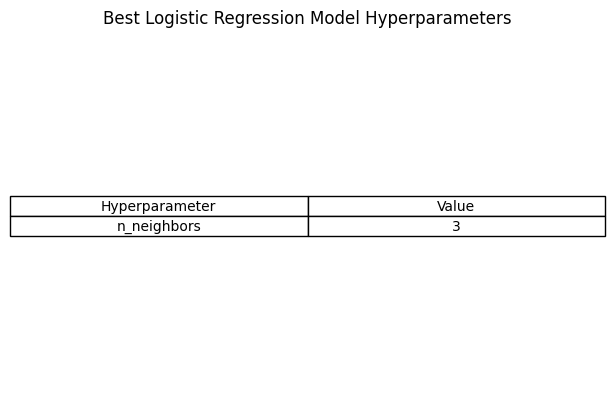

In [ ]:
knn_hyperparameter_table = [
    ["Hyperparameter", "Value"]
]

for key, val in knn_grid_search.best_params_.items():
  knn_hyperparameter_table.append([key.replace('knn__', ''), val])

create_table(knn_hyperparameter_table, 'Best Logistic Regression Model Hyperparameters')

## Model Metric Scores on Training Set

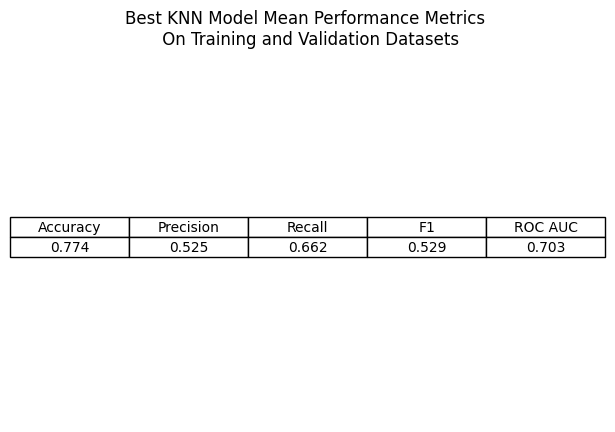

In [ ]:
knn_training_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

best_model_indx = knn_grid_search.best_index_
scoring_types = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
model_data = []

for st in scoring_types:
  model_data.append(round(knn_grid_search.cv_results_[f'mean_test_{st}'][best_model_indx], 3))

knn_training_metrics_table.append(model_data)

create_table(knn_training_metrics_table, 'Best KNN Model Mean Performance Metrics \n On Training and Validation Datasets')

## Model Metric Scores on Test Set

In [ ]:
knn_y_pred = knn_grid_search.predict(X_test)

knn_test_metrics = create_test_metrics_row(y_test, knn_y_pred, 'KNN')

test_metrics_data.append(knn_test_metrics)

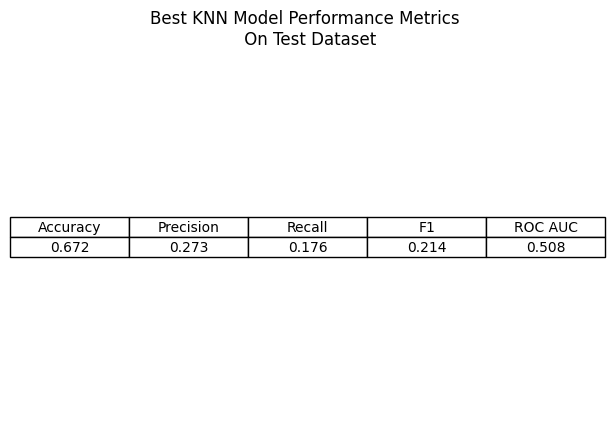

In [ ]:
knn_test_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

knn_test_metrics_table.append(knn_test_metrics[:len(knn_test_metrics) - 1])

create_table(knn_test_metrics_table, 'Best KNN Model Performance Metrics \n On Test Dataset')

In [ ]:
target_names = ['class 0: Patient Not Deceased', 'class 1: Patient Deceased']
print(classification_report(y_test, knn_y_pred, target_names=target_names))

                               precision    recall  f1-score   support

class 0: Patient Not Deceased       0.75      0.84      0.79        50
    class 1: Patient Deceased       0.27      0.18      0.21        17

                     accuracy                           0.67        67
                    macro avg       0.51      0.51      0.50        67
                 weighted avg       0.63      0.67      0.65        67



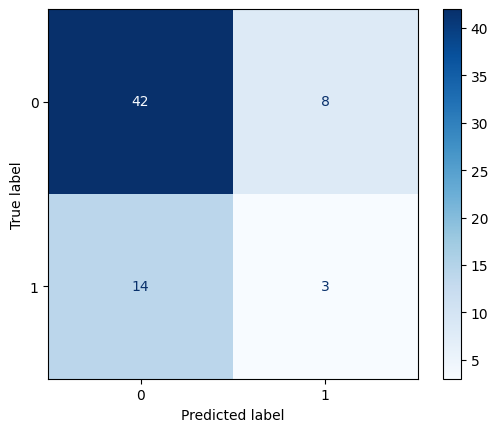

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, knn_y_pred, cmap=plt.cm.Blues)

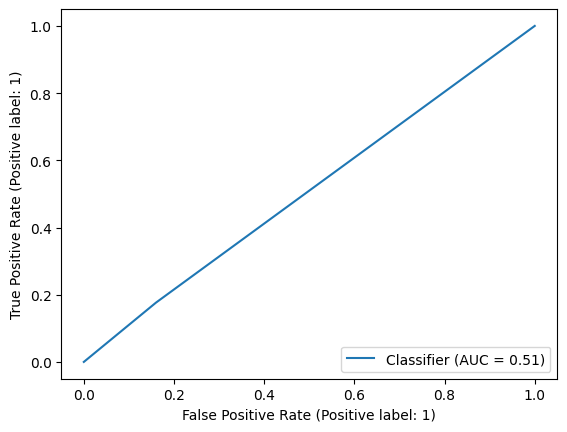

In [ ]:
RocCurveDisplay.from_predictions(y_test, knn_y_pred)

# Random Forest Classifier

## Hyperparameter Tuning With Stratified K-Fold CV and Grid Search CV

In [ ]:
random_forest_pipeline = Pipeline([
    ('scaler', standardizer),
    ('random_forest', RandomForestClassifier())
])

param_grid = {
    'random_forest__n_estimators': [25, 50, 100, 125, 150, 200],
    'random_forest__max_depth': [None, 5, 10, 25],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 5],
    'random_forest__max_features': ['sqrt', 'log2']
}

stratkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score, zero_division=1),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

random_forest_rs_search = RandomizedSearchCV(random_forest_pipeline, param_distributions=param_grid, scoring=scoring, refit='accuracy', cv=stratkf, n_jobs=-1)
random_forest_rs_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scale',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium'])])),
                                             ('random_forest',
                                              RandomForestClassifier())]),
                   n_jo...
                                        'random_forest__min_samples_leaf': [1,
                                                                            2,
                                                                            5],
                                        'random_forest__min_samples_split': [2,
                                                                             5,
                                                                             10],
                                        'random_forest__n_estimators': [25, 50,
                                                                        100,
                                                                        125,
                                                                        150,
                                                                        200]},
                   refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1': make_scorer(f1_score),
                            'precision': make_scorer(precision_score, zero_division=1),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score, needs_proba=True)})

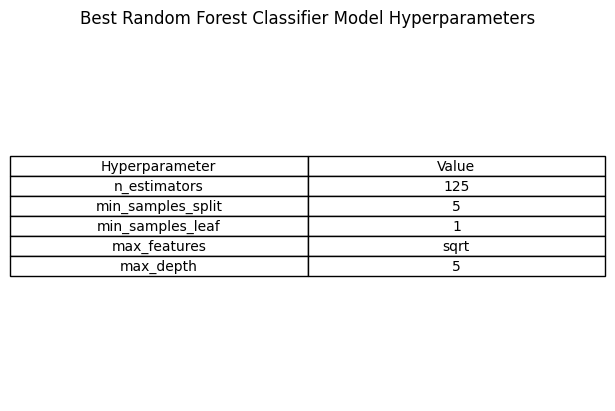

In [ ]:
random_forest_param_table = [
    ["Hyperparameter", "Value"]
]

for key, val in random_forest_rs_search.best_params_.items():
  random_forest_param_table.append([key.replace('random_forest__', ''), val])

create_table(random_forest_param_table, 'Best Random Forest Classifier Model Hyperparameters')

## Model Metric Scores on Training Set

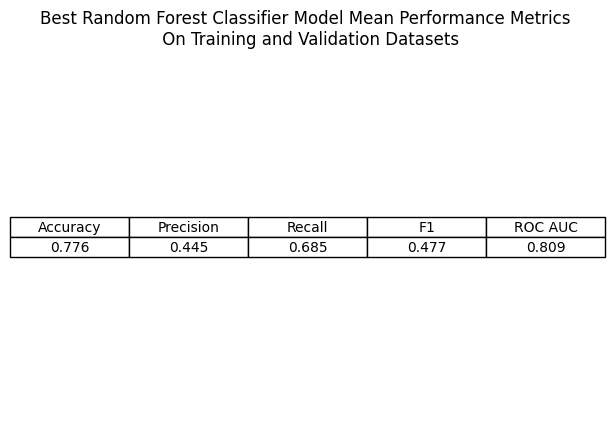

In [ ]:
random_forest_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

best_model_indx = random_forest_rs_search.best_index_
scoring_types = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
model_data = []

for st in scoring_types:
  model_data.append(round(random_forest_rs_search.cv_results_[f'mean_test_{st}'][best_model_indx], 3))

random_forest_metrics_table.append(model_data)

create_table(random_forest_metrics_table, 'Best Random Forest Classifier Model Mean Performance Metrics \n On Training and Validation Datasets')

## Model Metric Scores on Test Set

In [ ]:
rf_y_pred = random_forest_rs_search.predict(X_test)

rf_test_metrics = create_test_metrics_row(y_test, rf_y_pred, 'Random Forest Classifier')

test_metrics_data.append(rf_test_metrics)

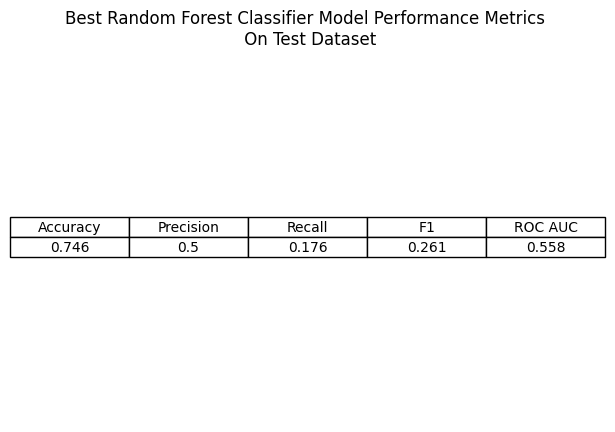

In [ ]:
rf_test_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

rf_test_metrics_table.append(rf_test_metrics[:len(rf_test_metrics) - 1])

create_table(rf_test_metrics_table, 'Best Random Forest Classifier Model Performance Metrics \n On Test Dataset')

In [ ]:
target_names = ['class 0: Patient Not Deceased', 'class 1: Patient Deceased']
print(classification_report(y_test, rf_y_pred, target_names=target_names))

                               precision    recall  f1-score   support

class 0: Patient Not Deceased       0.77      0.94      0.85        50
    class 1: Patient Deceased       0.50      0.18      0.26        17

                     accuracy                           0.75        67
                    macro avg       0.64      0.56      0.55        67
                 weighted avg       0.70      0.75      0.70        67



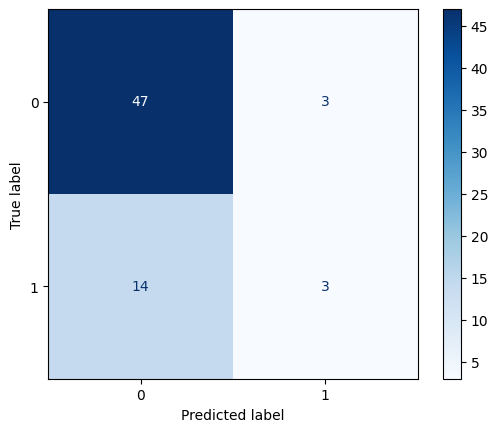

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_y_pred, cmap=plt.cm.Blues)

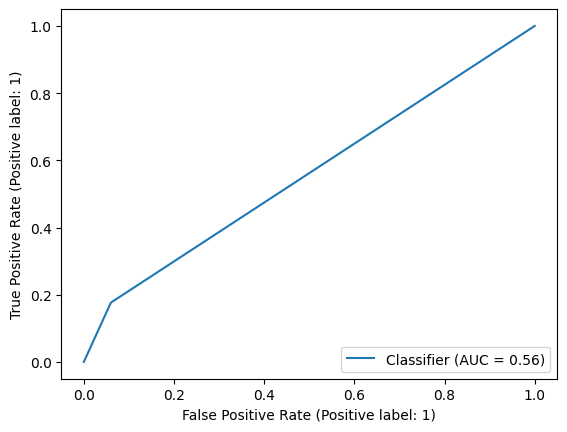

In [ ]:
RocCurveDisplay.from_predictions(y_test, rf_y_pred)

# Gradient Boosted Trees Classifier

## Hyperparameter Tuning With Stratified K-Fold CV and Grid Search CV

In [ ]:
gbc_pipeline = Pipeline([
    ('scaler', standardizer),
    ('gbc', GradientBoostingClassifier())
])

param_grid = {
    'gbc__n_estimators': [100, 200, 300],
    'gbc__learning_rate': [0.01, 0.1, 1.0],
    'gbc__max_depth': [3, 4, 5],
    'gbc__min_samples_split': [2, 3, 4],
    'gbc__min_samples_leaf': [1, 2, 3],
    'gbc__subsample': [0.5, 0.75, 1.0],
    'gbc__max_features': ['sqrt', 'log2', None]
}

stratkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score),
        'precision': make_scorer(precision_score, zero_division=1),
        'f1': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

gbc_rs_search = RandomizedSearchCV(gbc_pipeline, param_distributions=param_grid, scoring=scoring, refit='accuracy', cv=stratkf, n_jobs=-1)
gbc_rs_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scale',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'creatine_phosphokinase',
                                                                                'ejection_fraction',
                                                                                'platelets',
                                                                                'serum_creatinine',
                                                                                'serum_sodium'])])),
                                             ('gbc',
                                              GradientBoostingClassifier())]),
                   n_jobs=-1,...
                                        'gbc__min_samples_leaf': [1, 2, 3],
                                        'gbc__min_samples_split': [2, 3, 4],
                                        'gbc__n_estimators': [100, 200, 300],
                                        'gbc__subsample': [0.5, 0.75, 1.0]},
                   refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1': make_scorer(f1_score),
                            'precision': make_scorer(precision_score, zero_division=1),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score, needs_proba=True)})

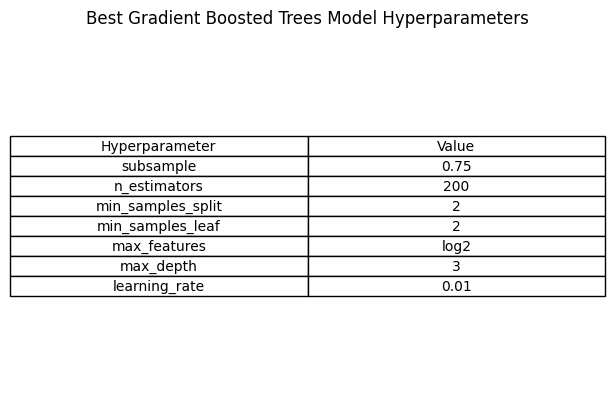

In [ ]:
gbc_param_table = [
    ["Hyperparameter", "Value"]
]

for key, val in gbc_rs_search.best_params_.items():
  gbc_param_table.append([key.replace('gbc__', ''), val])

create_table(gbc_param_table, 'Best Gradient Boosted Trees Model Hyperparameters')

## Model Metric Scores Training and Validation Sets With Cross Validation

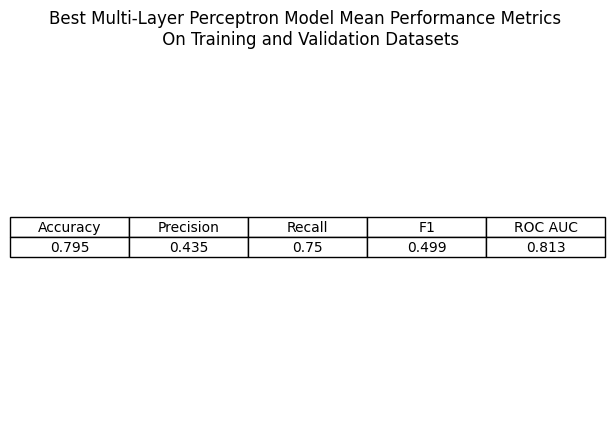

In [ ]:
gbc_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

best_model_indx = gbc_rs_search.best_index_
scoring_types = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
model_data = []

for st in scoring_types:
  model_data.append(round(gbc_rs_search.cv_results_[f'mean_test_{st}'][best_model_indx], 3))

gbc_metrics_table.append(model_data)

create_table(gbc_metrics_table, 'Best Multi-Layer Perceptron Model Mean Performance Metrics \n On Training and Validation Datasets')

## Model Metric Scores on Test Set

In [ ]:
gbc_y_pred = gbc_rs_search.predict(X_test)

gbc_test_metrics = create_test_metrics_row(y_test, gbc_y_pred, 'Gradient Boosted Tree')

test_metrics_data.append(gbc_test_metrics)

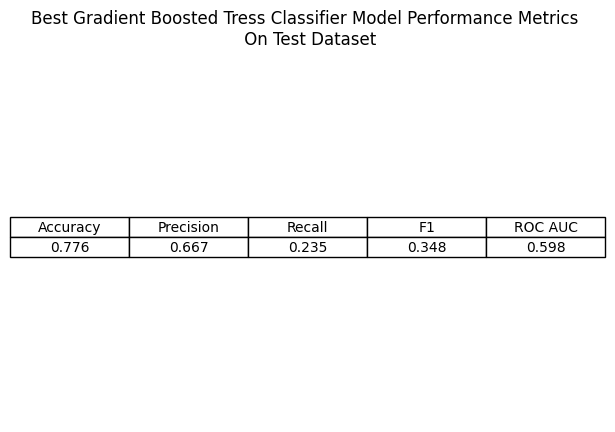

In [ ]:
gbc_test_metrics_table = [
    ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
]

gbc_test_metrics_table.append(gbc_test_metrics[:len(gbc_test_metrics) - 1])

create_table(gbc_test_metrics_table, 'Best Gradient Boosted Tress Classifier Model Performance Metrics \n On Test Dataset')

In [ ]:
target_names = ['class 0: Patient Not Deceased', 'class 1: Patient Deceased']
print(classification_report(y_test, gbc_y_pred, target_names=target_names))

                               precision    recall  f1-score   support

class 0: Patient Not Deceased       0.79      0.96      0.86        50
    class 1: Patient Deceased       0.67      0.24      0.35        17

                     accuracy                           0.78        67
                    macro avg       0.73      0.60      0.61        67
                 weighted avg       0.76      0.78      0.73        67



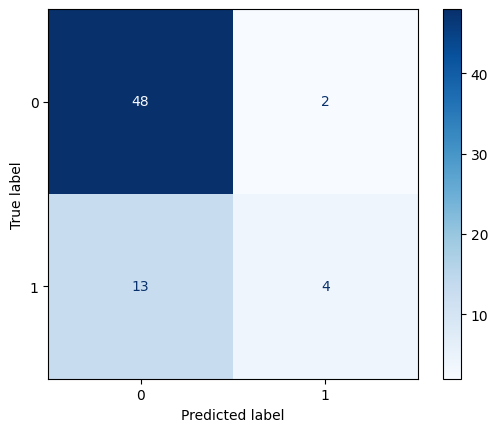

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, gbc_y_pred, cmap=plt.cm.Blues)

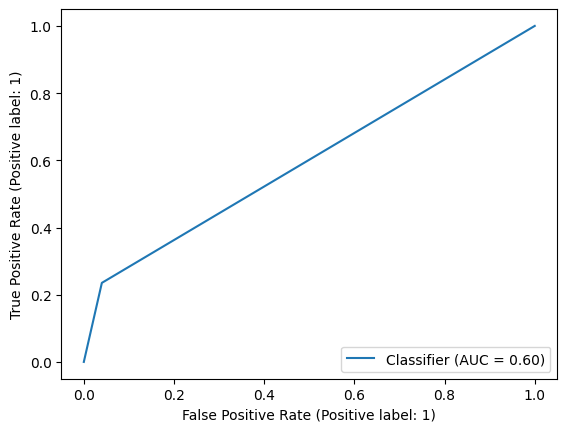

In [ ]:
RocCurveDisplay.from_predictions(y_test, gbc_y_pred)

# Model Test Metrics Comparison

In [ ]:
test_metrics_df = pd.DataFrame(test_metrics_data, columns=test_metrics_columns)
test_metrics_df

,Accuracy,Precision,Recall,F1,ROC AUC,Model
0,0.761,0.600,0.176,0.273,0.568,Logistic Regression
1,0.672,0.273,0.176,0.214,0.508,KNN
2,0.746,0.500,0.176,0.261,0.558,Random Forest Classifier
3,0.776,0.667,0.235,0.348,0.598,Gradient Boosted Tree


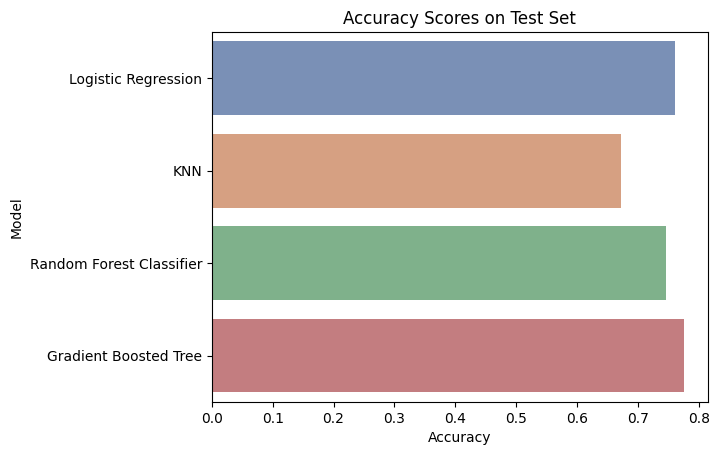

In [ ]:
sns.barplot(test_metrics_df, x='Accuracy', y='Model', hue='Model', palette="deep", alpha=.8)
plt.title('Accuracy Scores on Test Set')
plt.show()

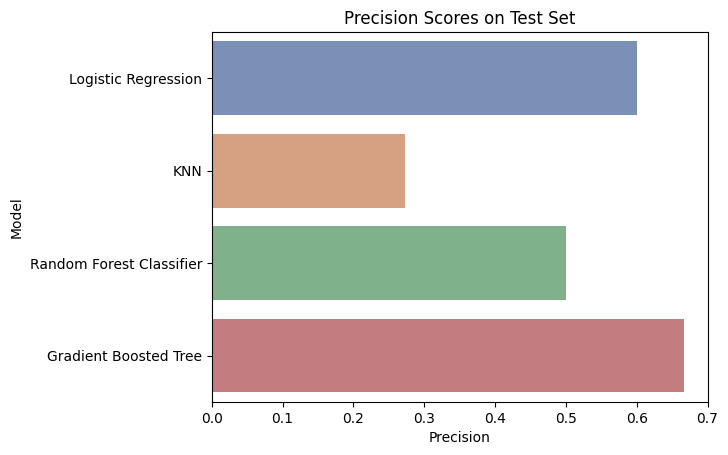

In [ ]:
sns.barplot(test_metrics_df, x='Precision', y='Model', hue='Model', palette="deep", alpha=.8)
plt.title('Precision Scores on Test Set')
plt.show()

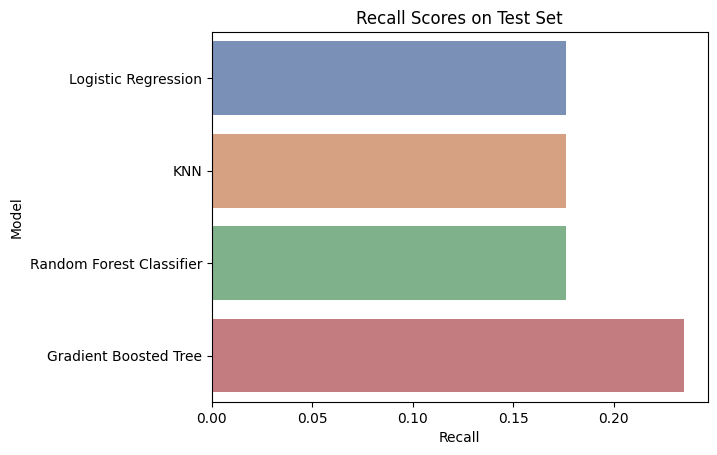

In [ ]:
sns.barplot(test_metrics_df, x='Recall', y='Model', hue='Model', palette="deep", alpha=.8)
plt.title('Recall Scores on Test Set')
plt.show()

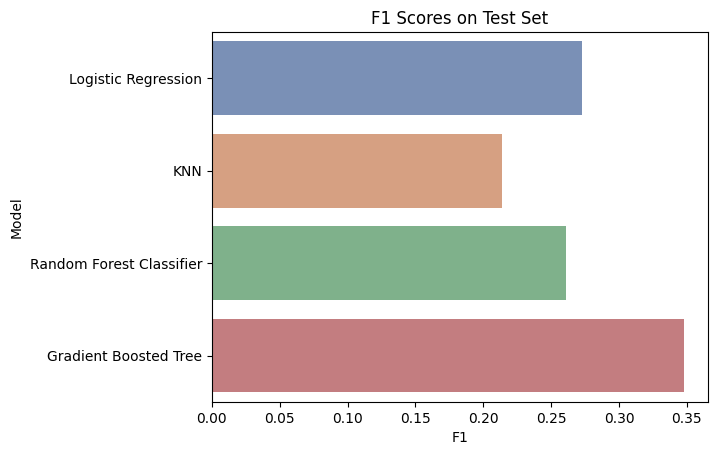

In [ ]:
sns.barplot(test_metrics_df, x='F1', y='Model', hue='Model', palette="deep", alpha=.8)
plt.title('F1 Scores on Test Set')
plt.show()

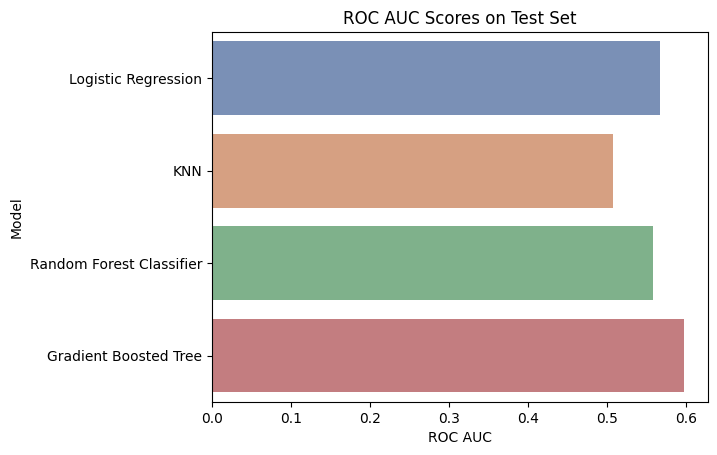

In [ ]:
sns.barplot(test_metrics_df, x='ROC AUC', y='Model', hue='Model', palette="deep", alpha=.8)
plt.title('ROC AUC Scores on Test Set')
plt.show()